# Cepstral strain mapping of PTO / DSO

This notebook measures the strain fields of an experimental 4D-STEM dataset recorded PTO on an DSO substrate.

[Download the experimental PTO dataset](https://drive.google.com/file/d/1zkCDTy5RWbJhrbLlCVvnJjsloDLmIPod/view?usp=sharing).

### Strain measurement

The method used to measure strain is the cepstral transform [TODO - add more info and ref]

### Acknowledgements

This tutorial was written by Ben Savitzky (bhsavitzky@lbl.gov) and Colin Ophus (clophus@lbl.gov) at Berkeley Lab.

This experimental dataset was provided by David Muller at Cornell [TODO-add other credits]
[TODO - add citation]


### Version
Last updated on 2021-07-28 with py4DSTEM version 0.12.4.

# Data file paths, imports

In [15]:
import py4DSTEM
import numpy as np

In [16]:
py4DSTEM.__version__

'0.12.3'

In [17]:
# File paths - output files will be augmented with the correct file extension
file_path_input = '/media/cophus/DATA/4DSTEM/PTODSO_small_128x130x64x64_float_x64_y64.raw'
file_path_output = '/media/cophus/DATA/4DSTEM/PTODSO_strain_cepstral'
# file_path_input = 'C:/data/SiGe_sims/Ge_SiGe_multilayer_stack_ideal.h5'
# file_path_output = 'C:/data/SiGe_sims/output_Ge_SiGe_multilayer_stack_ideal'

file_path_input = '/Users/Ben/Work/Data/py4DSTEM_tutorials/PTODSO_small_128x130x64x64_float_x64_y64.raw'
file_path_output = '/Users/Ben/Work/Data/py4DSTEM_tutorials/PTODSO_strain_cepstral'

In [18]:
# manual reading of EMPAD data
data_size = (64, 64, 130, 128)
dataset = py4DSTEM.io.DataCube(data=np.reshape(np.fromfile(file_path_input, dtype='16384float32'),data_size))

# Simple visualizations

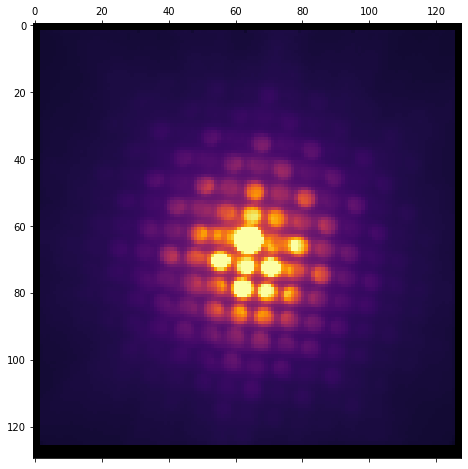

In [19]:
# Plot the mean CBED
diffraction_pattern_mean = np.mean(dataset.data, axis=(0,1))
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    clipvals='manual',
    min=0,
    max=4e4,
    scaling='power',
    power=0.5,
    cmap='inferno')

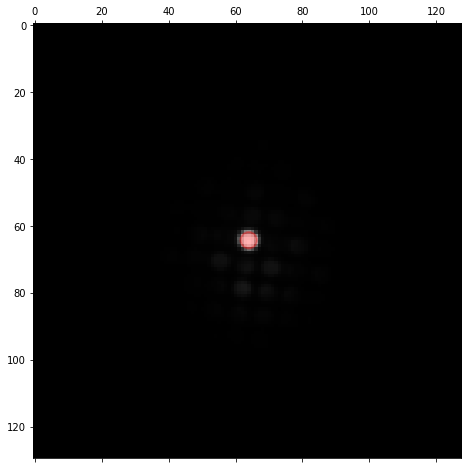

Estimated probe radius = 2.47 pixels


In [20]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(
    diffraction_pattern_mean)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    diffraction_pattern_mean, 
    (qx0, qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

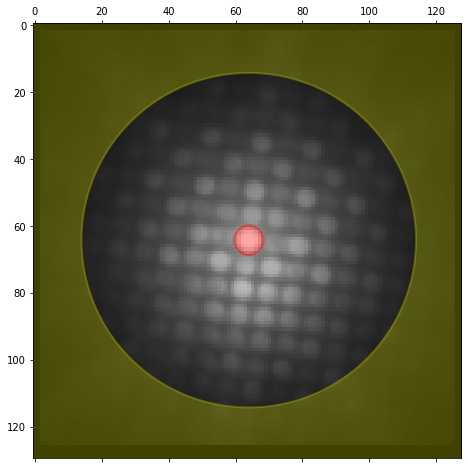

In [21]:
# Next, create a BF virtual detector using the the center beam position (qxy0, qy0), and a virtual DF detector.
# The DF virtual detector will be set to high scattering angles, picking up just a hint of the coherent diffraction.
expand_BF = 2.0
det_DF = (50,1000)

# Show selected virtual detectors
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    scaling='log',
    cmap='gray',
    circle={'R':probe_semiangle + expand_BF,
             'center':(qx0,qy0),
             'fill':True,
             'color':'r',
             'alpha':0.35},
    annulus={'Ri':det_DF[0],
             'Ro':det_DF[1],
             'center':(qx0,qy0),
             'fill':True,
             'color':'y',
             'alpha':0.35}
)

100%|██████████| 4096/4096 [00:00<00:00, 18683.32it/s]


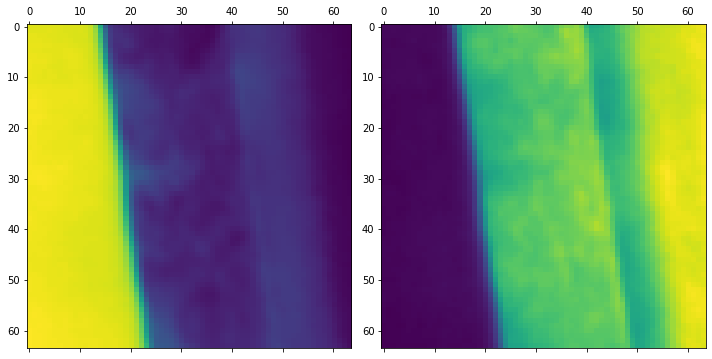

In [22]:
# Compute BF and DF virtual images
image_BF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset, 
    ((qx0, qy0), 
    probe_semiangle + expand_BF))
image_DF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset, 
    ((qx0, qy0), 
    (det_DF[0],
    det_DF[1])))

# Show the BF and DF images
py4DSTEM.visualize.show_image_grid(
    lambda i:[image_BF, image_DF][i],H=1,W=2,
    axsize=(5,5),
    cmap='viridis')

# Bragg disk detection

We can measure the disk spacing after applying the cepstral transform.  This will produce an strain map with the opposite sign as the correlation method (for small strain magnitudes).

In [23]:
# Define a cepstral transformation
cepstrum = py4DSTEM.process.utils.get_ewpc_filter_function(dataset.Q_Nx,dataset.Q_Ny)

In [24]:
# To prevent the log function from returning NaN for 0 inputs, we define a minimum intensity
min_int = 1

def ewpc(diff_pattern):
    return cepstrum(np.sqrt(diff_pattern**2 + min_int**2))

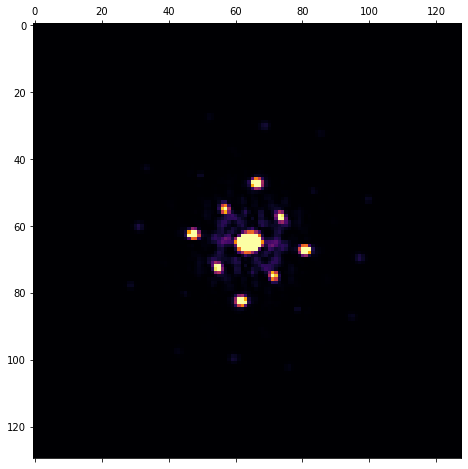

In [25]:
# Test application of our cepstral filter function
im = ewpc(dataset.data[30,35,:,:])

# plot the result
py4DSTEM.visualize.show(
    im,
    clipvals='manual',
    min=0,
    max=1e5,
    cmap='inferno')

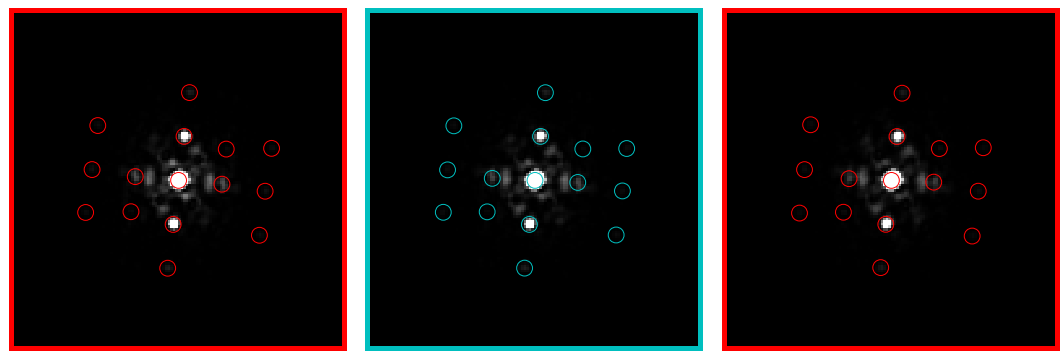

In [26]:
# Test hyperparameters on a few probe positions
rxs = 30,30,30
rys = 30,35,40
rys = 51,52,53
colors=['r','c','r','c','r','c']

dp0 = dataset.data[rxs[0],rys[0],:,:]
dp1 = dataset.data[rxs[1],rys[1],:,:]
dp2 = dataset.data[rxs[2],rys[2],:,:]

# Run the disk detection on the selected DPs
corrPower=1
sigma=0
edgeBoundary=8
minRelativeIntensity=0.000001
relativeToPeak=0
minPeakSpacing=13
maxNumPeaks=16
subpixel='poly'
upsample_factor=4

disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset,
    probe=None,
    Rx=rxs,
    Ry=rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor,
    filter_function=ewpc)

py4DSTEM.visualize.show_image_grid(
    lambda i:ewpc([dp0,dp1,dp2][i]),H=1,W=3,
    clipvals='manual',
    min=0,
    max=5e4,
    axsize=(5,5),
    get_bordercolor=lambda i:colors[i],                    
    get_x=lambda i:disks_selected[i].data['qx'],
    get_y=lambda i:disks_selected[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    open_circles=True,scale=250)

# Fit all Bragg peaks

In [27]:
# Find all Bragg peaks
# WARNING - this is the "slow" step, though it will only take ~1 minute for a dataset of this size.
# Note the speed depends strongly on whether 'multicorr' (more accurate) or 'poly' (faster) is used.
bragg_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=dataset,
    probe=None,                 
    corrPower=corrPower,                       
    sigma=sigma,                 
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,    
    upsample_factor=upsample_factor,
    filter_function=ewpc)

Finding Bragg Disks: 100%|██████████| 4.10k/4.10k [00:23<00:00, 172DP/s]


# Fit crystal lattice

In [28]:
# Center the peak positions about the origin.
bragg_peaks_centered = py4DSTEM.process.calibration.center_braggpeaks(
    bragg_peaks,
    qx0=qx0,
    qy0=qy0)

Computing Bragg vector map: 100%|██████████| 4.10k/4.10k [00:04<00:00, 835DP/s]


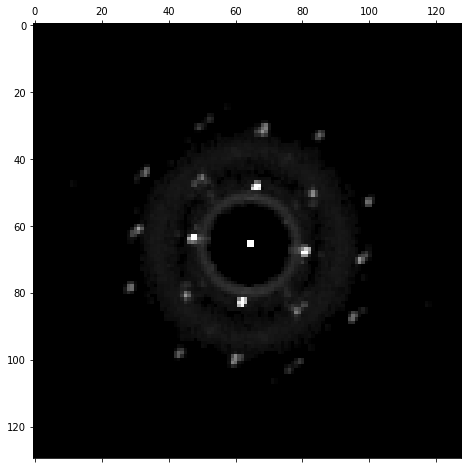

In [38]:
# Compute and plot Bragg vector map (BVM).
# This is a 2D histogram of all detected Bragg peaks.

# Compute the BVM
bragg_vector_map = py4DSTEM.process.diskdetection.get_bvm(
    bragg_peaks_centered,
    dataset.Q_Nx,
    dataset.Q_Ny)

# plot the BVM
py4DSTEM.visualize.show(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=1e8,
    scaling='power',
    power=0.25)

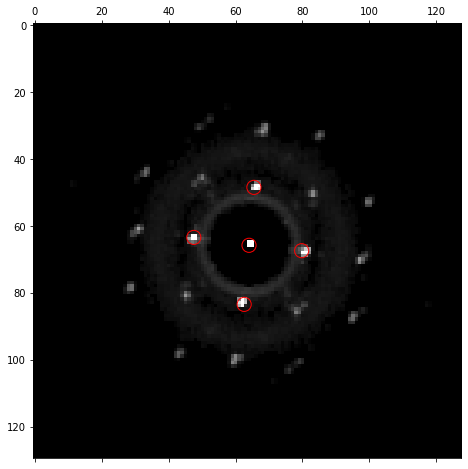

In [30]:
# Get all local maximum from the BVM, plot the candidate peaks
gx, gy, gI = py4DSTEM.process.utils.get_maxima_2D(
    bragg_vector_map,
    sigma=0, 
    edgeBoundary=4,
    minSpacing=4,
    minRelativeIntensity=0.00005,
    maxNumPeaks=200,
    subpixel='multicorr'
)

# Plot the candidate lattice coordinates
py4DSTEM.visualize.show_points(
    bragg_vector_map,
    x=gx,
    y=gy,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e8,
    scaling='power',
    power=0.25,
    open_circles=True,
    scale=200)

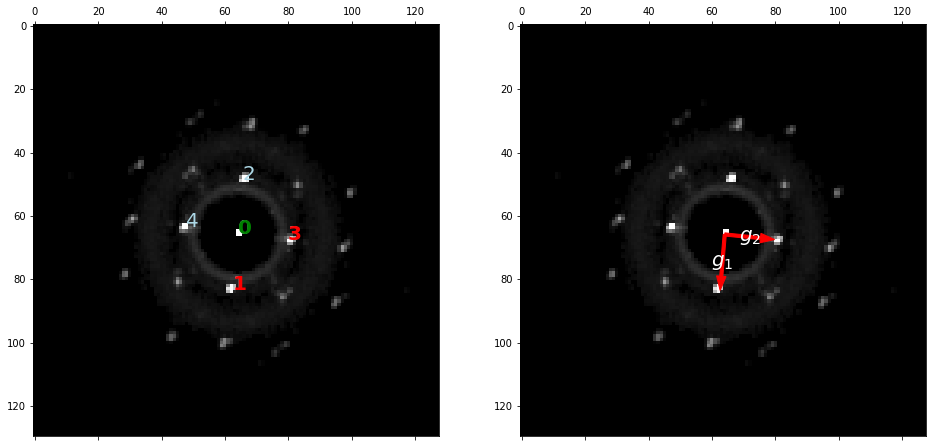

In [31]:
# Define peaks to use for computing strain maps
index_0, index_g1, index_g2 = 0, 1, 3

# Plot the selected lattice vectors - note they are in order of detected intensity
g1,g2 = py4DSTEM.visualize.select_lattice_vectors(
    bragg_vector_map,    
    figsize=(16,8),
    clipvals='manual',
    min=0,
    max=1e8,
    scaling='power',
    power=0.25,
    gx=gx,gy=gy,
    i0=index_0,
    i1=index_g1,
    i2=index_g2)

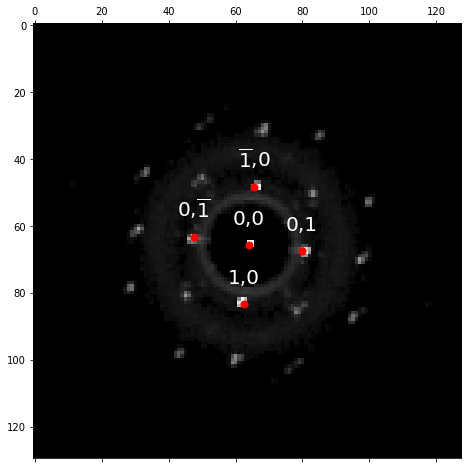

In [32]:
# Get indexing for all peaks, plot the indices overlaid onto the peaks
h, k, braggdirections = py4DSTEM.process.latticevectors.index_bragg_directions(
    qx0,qy0,
    gx,gy,
    g1,g2)
py4DSTEM.visualize.show_bragg_indexing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=1e8,
    scaling='power',
    power=0.25,
    figsize=(8,8),
    braggdirections=braggdirections,
    points=True)

In [33]:
# maximum peak spacing from expected positions
max_peak_spacing = 4

# Add indices to the bragg_peaks PointListArray
bragg_peaks_indexed = py4DSTEM.process.latticevectors.add_indices_to_braggpeaks(
    bragg_peaks_centered,
    braggdirections,
    maxPeakSpacing=max_peak_spacing,
    qx_shift=qx0,
    qy_shift=qy0)

In [34]:
# Fit the lattice in all diffraction images
g1g2_map = py4DSTEM.process.latticevectors.fit_lattice_vectors_all_DPs(bragg_peaks_indexed)

100%|██████████| 4096/4096 [00:00<00:00, 4692.40it/s]


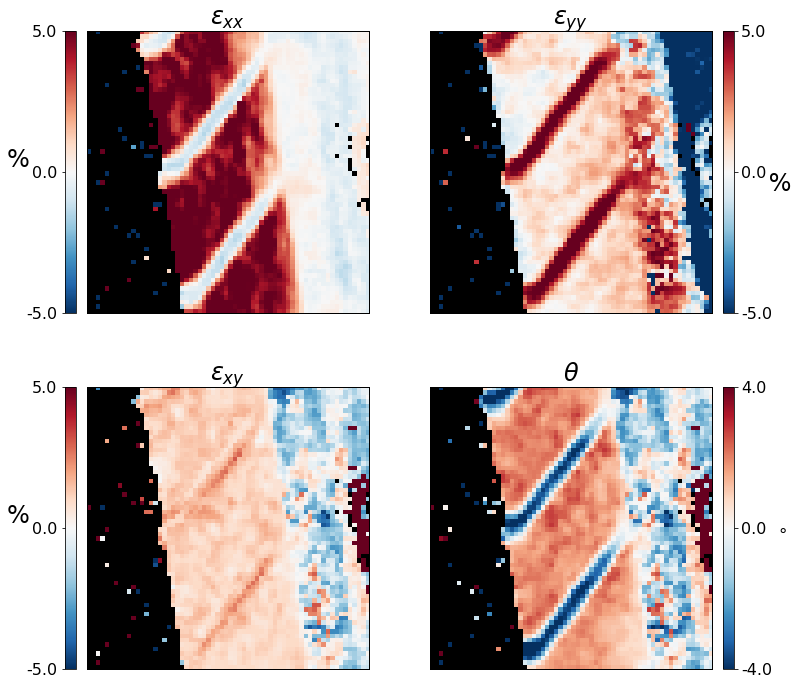

In [35]:
# Compute the strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset.R_Nx,dataset.R_Ny),dtype=bool))

# Rotate the lattice direction of the strain map 
# (pattern is rotated with respect to the scan direction)
g_reference = g1
strainmap = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_mediang1g2,
    g_reference[0],
    g_reference[1])

# Change the sign of E_xx, E_yy, E_xy for cepstral measurement
strainmap.slices['e_xx'] = -strainmap.slices['e_xx']
strainmap.slices['e_yy'] = -strainmap.slices['e_yy']
strainmap.slices['e_xy'] = -strainmap.slices['e_xy']

# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap,
    vrange_exx=[-5.0, 5.0],
    vrange_theta=[-4.0, 4.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(12,12))

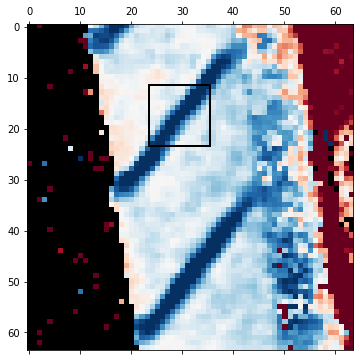

In [36]:
# Set the reference lattice to be the probe positions averaged across one of the inner domains.
x0,xf = 12,24
y0,yf = 24,36

py4DSTEM.visualize.show(
    strainmap.slices['e_yy'],              
    mask=strainmap.slices['mask'],
    figsize=(6, 6),
    clipvals='manual',
    min=-0.05,
    max=0.05,
    cmap='RdBu',
    rectangle={'lims':(x0,xf,y0,yf),'fill':False,'color':'k'})

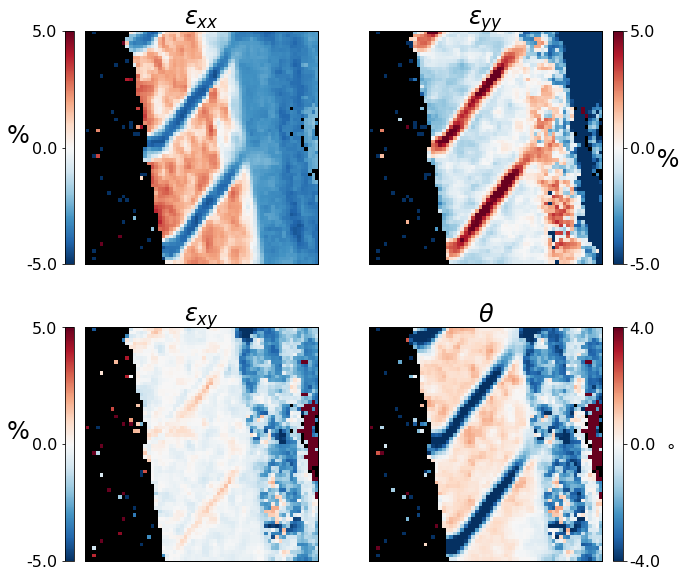

In [37]:
# Get new reference lattice vectors
mask = np.zeros((dataset.R_Nx,dataset.R_Ny),dtype=bool)
mask[x0:xf,y0:yf] = True
g1_ref,g2_ref = py4DSTEM.process.latticevectors.get_reference_g1g2(g1g2_map, mask)

# Recalculate the strain maps using the new reference lattice
strainmap_ROI_g1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_g1g2(
    g1g2_map,
    g1_ref,
    g2_ref)

# Rotate the lattice direction of the strain map 
strainmap_ROI = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_ROI_g1g2,
    g_reference[0],
    g_reference[1])

# Change the sign of E_xx, E_yy, E_xy for cepstral measurement
strainmap_ROI.slices['e_xx'] = -strainmap_ROI.slices['e_xx']
strainmap_ROI.slices['e_yy'] = -strainmap_ROI.slices['e_yy']
strainmap_ROI.slices['e_xy'] = -strainmap_ROI.slices['e_xy']

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI,
    vrange_exx=[-5.0, 5.0],
    vrange_theta=[-4.0, 4.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(10,10),
    returnfig=True)

# Save data and strain maps

In [46]:
# Strain map figure
fig.savefig(file_path_output + '.pdf')

In [47]:
# Save all data in py4DSTEM format
# The diffraction space arrays we will save are:
file_path_output_h5 =  file_path_output + '.h5'
diff = py4DSTEM.io.DiffractionSlice(
    data=np.dstack([diffraction_pattern_mean, 
                    ]),    
    slicelabels=['image_mean',
                 ],
    name='diffraction_images')

# The real space arrays we will save are:
real = py4DSTEM.io.RealSlice(
    data=np.dstack([image_BF, 
                    image_DF]),    
    slicelabels=['bright_field',
                 'dark_field'],
    name='real_space_images')

# Note we will also save the strain maps, but these are already stored as RealSlice objects.
# We will also store the center coordinates, estimated radius in pixels, strain reference direction,
# but most importantly - the Bragg disk positions and intensities (bragg_peaks_centered).
probe_fields = [("probe_semiangle",float),
              ("qx0", float),
              ("qy0", float)]
probe_data = py4DSTEM.io.PointList(coordinates=probe_fields)
probe_data.add_point((probe_semiangle, qx0, qy0))
probe_data.name = 'probe_data'

# Save all of the resulting data into a single .h5 file:
py4DSTEM.io.save(file_path_output_h5,
                 [diff,
                  real,
                  probe_data,
                  strainmap_ROI,                  
                  bragg_peaks_centered],
                 overwrite=True)

 20%|██        | 835/4096 [00:00<00:00, 4062.76it/s]

Saving DiffractionSlice 'diffraction_images'...
Saving RealSlice 'real_space_images'...
Saving PointList 'probe_data'...
Saving RealSlice 'strain_map_rotated'...
Saving PointListArray 'braggpeaks_centered'...


100%|██████████| 4096/4096 [00:00<00:00, 4319.49it/s]


In [48]:
# Check the results of the h5 file we just created
py4DSTEM.io.read(file_path_output_h5)

py4DSTEM file version 0.12.3
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DiffractionSlice  (130, 128, 1)           diffraction_images                                    
  1       RealSlice         (64, 64, 2)             real_space_images                                     
  2       RealSlice         (64, 64, 5)             strain_map_rotated                                    
  3       PointList         (3, 1)                  probe_data                                            
  4       PointListArray    (64, 64, 3, -1)         braggpeaks_centered                                   
